#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
### We compare TAVIE for the Student's-t model against competing methods.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

This `ipynb` compares the **TAVIE** algorithm to different state-of-the-art variational algorithms applied under Student's-t SSG likleihood.
* **Student's-t SSG**: `TAVIE` versus `MFVI` (<doi:10.1214/11-BA631>), `ADVI mean-field`, `ADVI full-rank`, `DADVI` and `NUTS`.

In [1]:
# Required for DADVI experiments, running TAVIE and other BBVI algorithms
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import arviz as az
import re

### True synthetic Student's-t data generation, n=10000, p=5 (+ intercept)

In [2]:
# Generate synthetic data for Student's-t regression
n = 10000
p = 5
tau2_true = 8
df = 5
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

### Code for the Student's-t PyMC model and fitting Student's-t NUTS model || Also fitting the TAVIE Student's-t model || Fitting ADVI algorithms || Fitting the MFVI for Student's-t model

In [3]:
def student_t_pymc_model(X, y, nu, a0=0.05, b0=0.05):
    """
    Student's-t regression with known nu:
        y ~ StudentT(nu, mu = X @ beta, sigma = 1/sqrt(tau2))

    Priors:
        beta ~ Normal(0, 1)      (vector length p)
        tau2 ~ Gamma(a0/2, b0/2) [shape-rate]
    """
    # ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n, p = X.shape
    dtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # data
        X_data = pm.MutableData("X", X.astype(dtype))
        y_data = pm.MutableData("y", y.astype(dtype))

        # priors
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)
        tau2 = pm.Gamma("tau2", alpha=a0/2, beta=b0/2)   # precision

        # mean
        mu = pt.dot(X_data, beta)

        # Student-t likelihood with known nu
        pm.StudentT("y_obs", nu=nu, mu=mu, sigma=1 / pt.sqrt(tau2), observed=y_data)

    return model


def fit_NUTS_student_t(model):
    """
    Fit the Student's-t model with NUTS and return posterior means for beta and tau2.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    # Fitting the NUTS model
    with model as model:
        nuts_model = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(nuts_model, var_names=["beta", "tau2"])[["mean"]]

    # tau2 mean (scalar)
    tau2_mean = float(summ.loc[summ.index == "tau2", "mean"].values[0])

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    post_means = {"beta": np.array(beta_mean), "tau2": tau2_mean}
    return post_means

In [4]:
# Initialize Student's-t PyMC model for DADVI
student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)

# Initialize the Student's-t TAVIE model
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# Now fit DADVI
student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()

# Now fitting and obtaining results from the NUTS Laplace model
student_nuts_res = fit_NUTS_student_t(student_dadvi_model)

# Now fitting the TAVIE model for Laplace regression
student_tavie_model.fit(X, y, nu=df, verbose=False)
student_tavie_res = student_tavie_model.get_TAVIE_means(verbose=False)

# Now fitting ADVI mean-field (BBVI) and ADVI full-rank (BBVI fullcov)
student_advi_mf_res = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=0.025, b0=0.025, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
student_advi_fr_res = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=np.eye(p+1), a0=0.025, b0=0.025, lr=1e-3, patience=1e4,
                                                      tol=1e-9, verbose=False)

# Now fitting MFVI for the Student's-t model
beta_hat_MFVI, sigma_sq_hat_MFVI, nu_hat_MFVI = MFVI_Student(X_bbvi, y, 
                                                  mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                  A=2, B=2, nu_min=2.0, 
                                                  nu_max=20.0, tol=1e-6, verbose = False)

### TAVIE, MFVI, DADVI, ADVI, and NUTS Results

In [5]:
print("################################")
print("-----------Ground Truth---------")
print("################################")
print(f"beta={beta_true}")
print(f"tau2={tau2_true}")

print("\n")

print("################################")
print("-----------TAVIE results---------")
print("################################")
print(f"beta.est={student_tavie_res[0]}")
print(f"tau2.est={student_tavie_res[1]}")

print("\n")

print("################################")
print("-----------MFVI results---------")
print("################################")
print(f"beta.est={beta_hat_MFVI}")
print(f"tau2.est={1 / sigma_sq_hat_MFVI}")

print("\n")

print("################################")
print("-----------DADVI results---------")
print("################################")
print(f"beta.est={student_dadvi_res['beta']}")
print(f"tau2.est={np.exp(student_dadvi_res['tau2_log__'])}")

print("\n")

print("################################")
print("-----------ADVI mean-field results---------")
print("################################")
print(f"beta.est={student_advi_mf_res['beta_mean']}")
print(f"tau2.est={student_advi_mf_res['tau2_mean']}")

print("\n")

print("################################")
print("-----------ADVI full-rank results---------")
print("################################")
print(f"beta.est={student_advi_fr_res['beta_mean']}")
print(f"tau2.est={student_advi_fr_res['tau2_mean']}")

print("\n")

print("################################")
print("-----------NUTS results---------")
print("################################")
print(f"beta.est={student_nuts_res['beta']}")
print(f"tau2.est={student_nuts_res['tau2']}")

################################
-----------Ground Truth---------
################################
beta=[ 0.43949624  0.45117375 -0.29650966  0.95539454  2.66823057 -1.05252119]
tau2=8


################################
-----------TAVIE results---------
################################
beta.est=[ 0.43654584  0.4522242  -0.2985729   0.94864333  2.66769698 -1.05402881]
tau2.est=7.898899196928308


################################
-----------MFVI results---------
################################
beta.est=[ 0.43657923  0.45225204 -0.29862277  0.94872121  2.66800118 -1.05413641]
tau2.est=7.877768479797133


################################
-----------DADVI results---------
################################
beta.est=[ 0.43622816  0.45205926 -0.29887836  0.94971833  2.66809864 -1.0545349 ]
tau2.est=7.9839047352563135


################################
-----------ADVI mean-field results---------
################################
beta.est=[ 0.4386715   0.44886303 -0.30041936  0.9511597   2.665509

### For a fixed sample size n=1000 and fixed featured p=5

In [6]:
# TAVIE model initialization
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# Experiment parameters
n = 1000
p = 5
tau2_true = 3
df = 5
num_reps = 100
# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Containers for metrics
mse_beta_ADVI_mf = np.zeros(num_reps)
mse_beta_ADVI_fr = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_DADVI = np.zeros(num_reps)
mse_beta_NUTS = np.zeros(num_reps)
mse_beta_MFVI = np.zeros(num_reps)

mse_tau2_ADVI_mf = np.zeros(num_reps)
mse_tau2_ADVI_fr = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
mse_tau2_DADVI = np.zeros(num_reps)
mse_tau2_NUTS = np.zeros(num_reps)
mse_tau2_MFVI = np.zeros(num_reps)

time_TAVIE = np.zeros(num_reps)
time_ADVI_mf = np.zeros(num_reps)
time_ADVI_fr = np.zeros(num_reps)
time_DADVI = np.zeros(num_reps)
time_NUTS = np.zeros(num_reps)
time_MFVI = np.zeros(num_reps)

# prior choice
Sigma_prior = np.eye(p + 1)
a = 0.025
b = 0.025

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    np.random.seed(rep)
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # MFVI estimator
    t0 = perf_counter()
    beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                  mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                  A=2, B=2, nu_min=2.0, 
                                                  nu_max=20.0, tol=1e-6, verbose = False)
    time_MFVI[rep] = perf_counter() - t0
    beta_est2 = beta_hat
    tau2_est2 = 1/sigma_sq_hat
    mse_beta_MFVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_MFVI[rep] = (tau2_est2 - tau2_true)**2

    # DADVI estimator
    student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)
    t0 = perf_counter()
    student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()
    time_DADVI[rep] = perf_counter() - t0
    beta_est_DADVI = student_dadvi_res['beta']
    tau2_est_DADVI = np.exp(student_dadvi_res['tau2_log__'])
    mse_beta_DADVI[rep] = np.mean((beta_est_DADVI - beta_true)**2)
    mse_tau2_DADVI[rep] = (tau2_est_DADVI - tau2_true)**2

    # NUTS estimator
    t0 = perf_counter()
    student_nuts_res = fit_NUTS_student_t(student_dadvi_model)
    time_NUTS[rep] = perf_counter() - t0
    beta_est_NUTS = student_nuts_res['beta']
    tau2_est_NUTS = student_nuts_res['tau2']
    mse_beta_NUTS[rep] = np.mean((beta_est_NUTS - beta_true)**2)
    mse_tau2_NUTS[rep] = (tau2_est_NUTS - tau2_true)**2

    # TAVIE estimator
    t0 = perf_counter()
    student_tavie_model.fit(X, y, nu=df, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est_TAVIE - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est_TAVIE - tau2_true)**2

    # ADVI mean-field estimator
    t0 = perf_counter()
    res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
    time_ADVI_mf[rep] = perf_counter() - t0
    beta_est_ADVI_mf = res2['beta_mean']
    tau2_est_ADVI_mf = res2['tau2_mean']
    mse_beta_ADVI_mf[rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    mse_tau2_ADVI_mf[rep] = (tau2_est_ADVI_mf - tau2_true)**2

    # ADVI full-rank estimator
    t0 = perf_counter()
    res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                      tol=1e-9, verbose=False)
    time_ADVI_fr[rep] = perf_counter() - t0
    beta_est_ADVI_fr = res3['beta_mean']
    tau2_est_ADVI_fr = res3['tau2_mean']
    mse_beta_ADVI_fr[rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
    mse_tau2_ADVI_fr[rep] = (tau2_est_ADVI_fr - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_MFVI':     mse_beta_MFVI,
    'mse_tau2_MFVI':     mse_tau2_MFVI,
    'time_MFVI':         time_MFVI,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Student_metrics_n_{n}_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

Repetitions: 100%|█████████████████████| 100/100 [34:57<00:00, 20.97s/it]


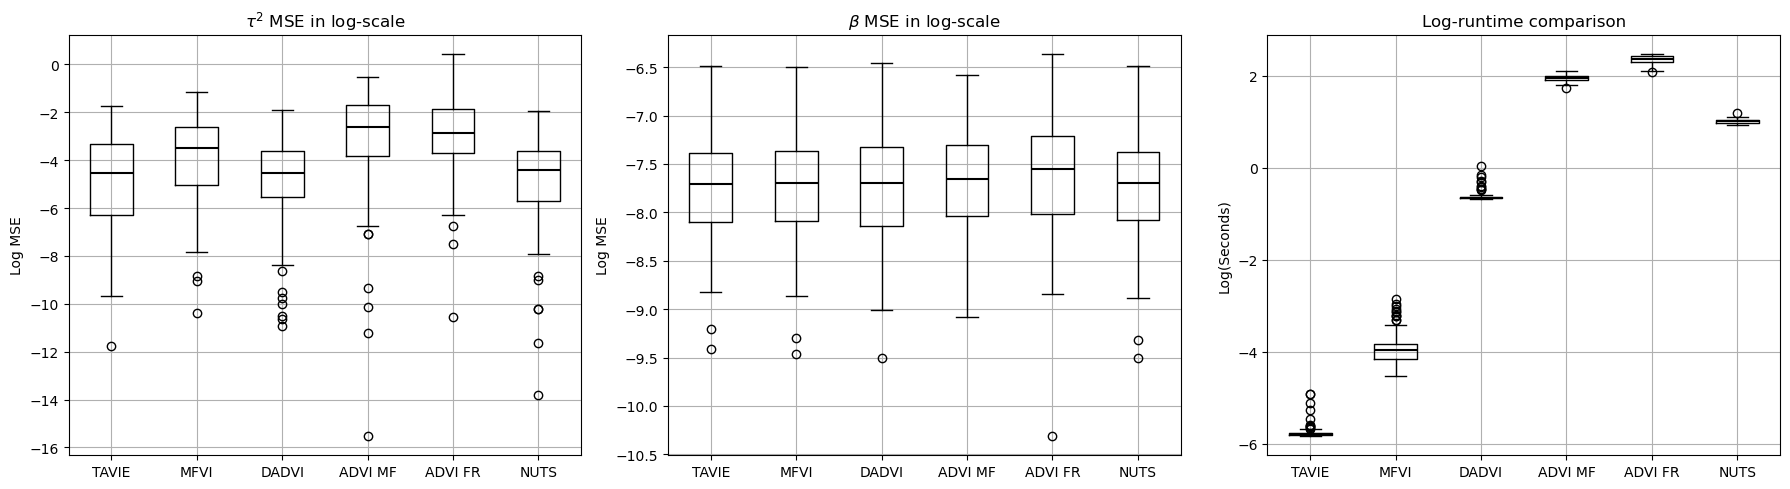

In [7]:
# plotting the results for TAVIE, MFVI, DADVI, BBVI, and NUTS

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# Tau^2 MSE comparison
axes[0].boxplot([np.log(mse_tau2_TAVIE), np.log(mse_tau2_MFVI), np.log(mse_tau2_DADVI), np.log(mse_tau2_ADVI_mf), 
                 np.log(mse_tau2_ADVI_fr), np.log(mse_tau2_NUTS)], 
                tick_labels=['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[0].set_title(r'$\tau^2$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([np.log(mse_beta_TAVIE), np.log(mse_beta_MFVI), np.log(mse_beta_DADVI), np.log(mse_beta_ADVI_mf), 
                 np.log(mse_beta_ADVI_fr), np.log(mse_beta_NUTS)], 
                tick_labels=['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[1].set_title(r'$\beta$ MSE in log-scale')
axes[1].set_ylabel('Log MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_MFVI), np.log(time_DADVI), np.log(time_ADVI_mf), np.log(time_ADVI_fr), np.log(time_NUTS)], 
                tick_labels=['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
fig.savefig(f'results_compete/plots/Student_metrics_n_{n}_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()

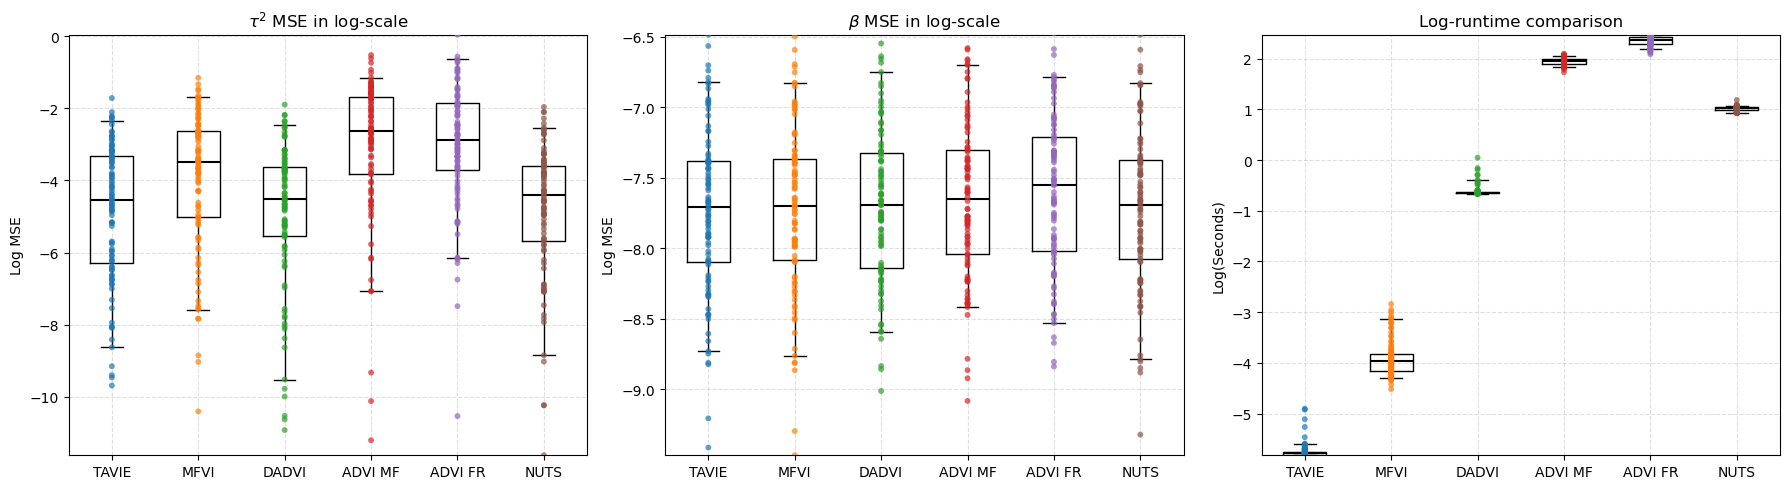

In [8]:
# plotting the results for TAVIE, MFVI, DADVI, BBVI, and NUTS

labels = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
eps = 1e-16  # avoid log(0)

# prepare log-data (original values, no jitter)
tau2_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]]
beta_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]]
time_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [time_TAVIE, time_MFVI, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# --- τ² MSE ---
axes[0].boxplot(tau2_logs, tick_labels=labels, showfliers=False, whis=(5, 95), medianprops=median_kws)
axes[0].set_title(r'$\tau^2$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(tau2_logs, start=1):
    x = np.full(y.shape, i, dtype=float)  # exact category center, no jitter
    axes[0].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# --- β MSE ---
axes[1].boxplot(beta_logs, tick_labels=labels, showfliers=False, whis=(5, 95), medianprops=median_kws)
axes[1].set_title(r'$\beta$ MSE in log-scale')
axes[1].set_ylabel('Log MSE')
axes[1].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(beta_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[1].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# --- Runtime ---
axes[2].boxplot(time_logs, tick_labels=labels, showfliers=False, whis=(5, 95), medianprops=median_kws)
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(time_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[2].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# optional: robust y-limits so tiny spreads aren’t crushed by outliers
for ax, logs in zip(axes, [tau2_logs, beta_logs, time_logs]):
    allv = np.concatenate([v for v in logs if len(v)])
    ax.set_ylim(*np.percentile(allv, [0.5, 99.5]))

plt.tight_layout()
fig.savefig(f'results_compete/plots/Student_metrics_n_{n}_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()

### For multiple sample sizes n and fixed features p=5

In [9]:
# ==== Experiment settings ====
p = 5
tau2_true = 3.0
df = 5
num_reps = 100
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
mse_tau2_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_MFVI          = np.zeros((n_sizes, num_reps))
mse_tau2_MFVI          = np.zeros((n_sizes, num_reps))
time_MFVI              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
mse_tau2_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
mse_tau2_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# Initialize TAVIE once
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
        y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

        # ---- TAVIE ----
        t0 = perf_counter()
        student_tavie_model.fit(X, y, nu=df, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # MFVI estimator
        t0 = perf_counter()
        beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                      mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                      A=2, B=2, nu_min=2.0, 
                                                      nu_max=20.0, tol=1e-6, verbose = False)
        time_MFVI[i, rep] = perf_counter() - t0
        beta_est2 = beta_hat
        tau2_est2 = 1/sigma_sq_hat
        mse_beta_MFVI[i, rep] = np.mean((beta_est2 - beta_true)**2)
        mse_tau2_MFVI[i, rep] = (tau2_est2 - tau2_true)**2

        # DADVI estimator
        student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)
        t0 = perf_counter()
        student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = student_dadvi_res['beta']
        tau2_est_DADVI = np.exp(student_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        student_nuts_res = fit_NUTS_student_t(student_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = student_nuts_res['beta']
        tau2_est_NUTS = student_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        tau2_est_ADVI_mf = res2['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_est_ADVI_mf - tau2_true)**2

        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                          tol=1e-9, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        tau2_est_ADVI_fr = res3['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_est_ADVI_fr - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_MFVI':     mse_beta_MFVI,
    'mse_tau2_MFVI':     mse_tau2_MFVI,
    'time_MFVI':         time_MFVI,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Student_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=200:   1%|▎                            | 1/100 [00:19<31:21, 19.00s/it]

n=200:  22%|██████▏                     | 22/100 [06:31<22:43, 17.48s/it]

n=200:  35%|█████████▊                  | 35/100 [10:22<19:10, 17.71s/it]

n=200:  44%|████████████▎               | 44/100 [12:54<15:52, 17.01s/it]

n=200:  45%|████████████▌               | 45/100 [13:12<15:47, 17.23s/it]

n=200:  49%|█████████████▋              | 49/100 [14:25<15:11, 17.88s/it]

n=200:  57%|███████████████▉            | 57/100 [16:44<12:27, 17.39s/it]

n=200:  63%|█████████████████▋          | 63/100 [18:32<11:11, 18.15s/it]

n=200:  67%|██████████████████▊         | 67/100 [19:40<09:35, 17.45s/it]

n=200:  72%|████████████████████▏       | 72/100 [21:07<08:08, 17.44s/it]

n=200:  76%|█████████████████████▎      | 76/100 [22:19<07:09, 17.91s/it]

n=200:  82%|██████████████████████▉     | 82/100 [24:08<05:24, 18.02s/it]

n=200:  97%|███████████████████████████▏| 97/100 [28:33<00:54, 18.03s/it]

n=500:  61%|█████████████████           | 61/100 [19:39<13:00, 20.01s/it]

n=500:  95%|██████████████████████████▌ | 95/100 [30:55<01:42, 20.56s/it]

n=2000: 100%|██████████████████████████| 100/100 [39:50<00:00, 23.91s/it]


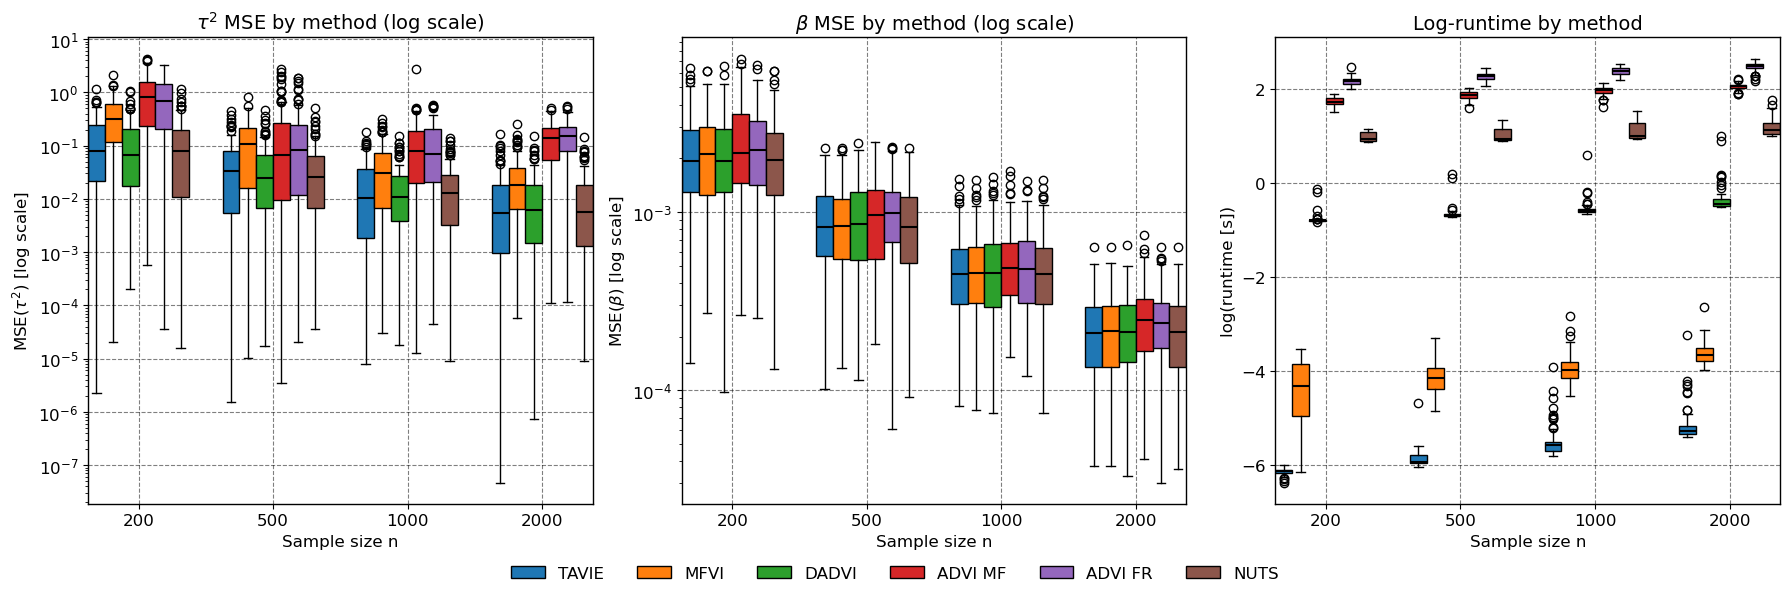

In [10]:
# plotting the results for TAVIE, MFVI, DADVI, ADVI, and NUTS over the choice of different sample sizes n

methods  = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2', 'C3', 'C4', 'C5']
n_sizes  = len(sample_sizes)
x        = np.arange(n_sizes)
width    = 0.2

# --- spacing controls ---
M             = len(methods)
group_spacing = 8.0   # gap between n-groups on x-axis
method_step   = 1.0  # separation between methods within a group
box_width     = 1.0  # width of each box
centers       = np.arange(n_sizes) * group_spacing

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)

# 3) Runtime (log scale on the data)
ax = axes[2]
for j, arr in enumerate([time_TAVIE, time_MFVI, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(len(methods))]
fig.legend(handles=handles, loc='lower center', ncol=6, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Student_metrics_multi_n_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()


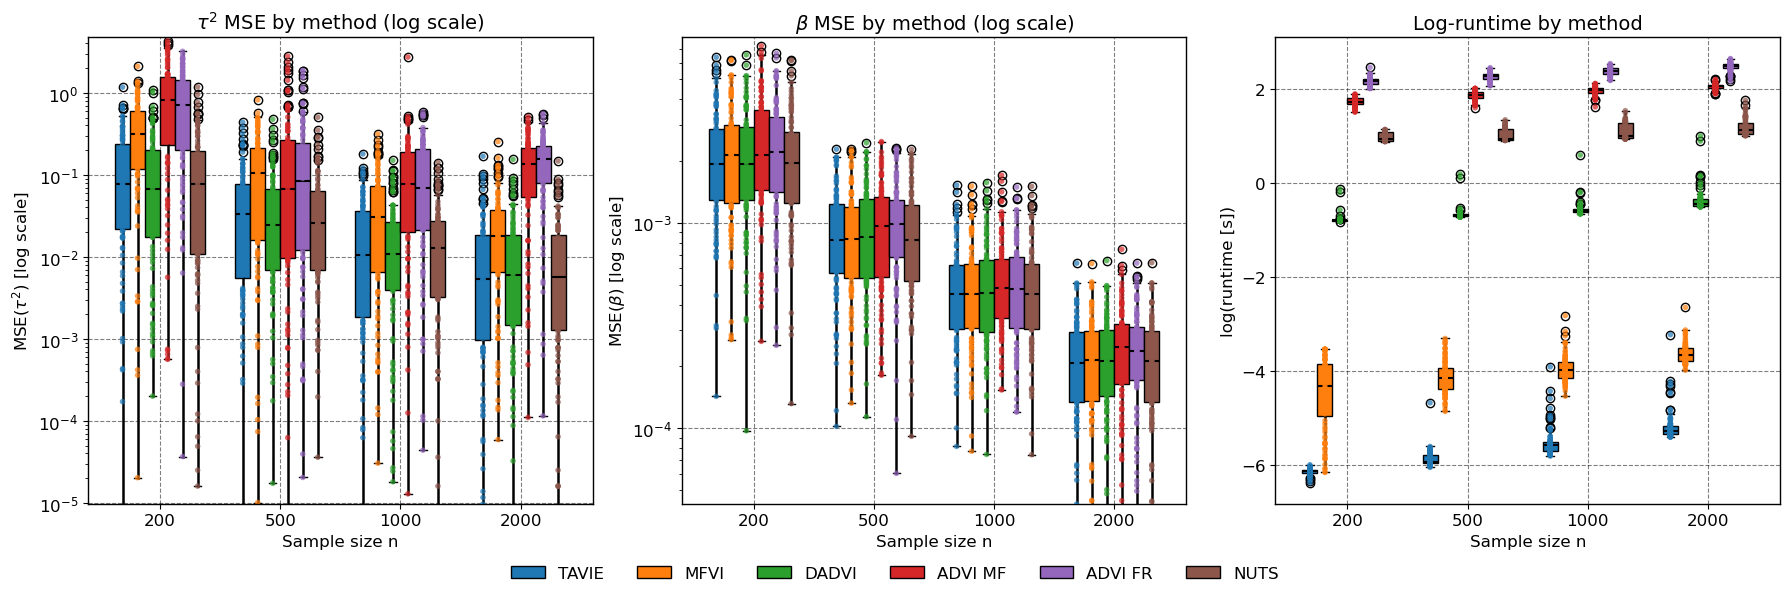

In [11]:
# plotting the results for TAVIE, MFVI, DADVI, ADVI, and NUTS over different sample sizes n

methods  = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2',     'C3',      'C4',     'C5']
n_sizes  = len(sample_sizes)
M        = len(methods)
eps      = 1e-16  # avoid log(0) in log-scale panels

# --- spacing controls ---
group_spacing = 8.0    # gap between n-groups on x-axis
method_step   = 1      # separation between methods within a group
box_width     = 1      # width of each box
centers       = np.arange(n_sizes) * group_spacing

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# Common boxplot style (no end caps)
bp_kwargs = dict(
    widths=box_width,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.8, color='black'),
    medianprops=dict(linewidth=1.5, color='black'),
)

# 1) τ² MSE (log axis)
ax = axes[0]
all_vals_tau2 = []
series_tau2 = [mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]
for j, arr in enumerate(series_tau2):
    data = [np.clip(arr[i, :], eps, None) for i in range(n_sizes)]  # ensure >0
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped) at exact positions
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_tau2.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 2) β MSE (log axis)
ax = axes[1]
all_vals_beta = []
series_beta = [mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]
for j, arr in enumerate(series_beta):
    data = [np.clip(arr[i, :], eps, None) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped)
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_beta.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log on the DATA; linear axis)
ax = axes[2]
all_vals_time = []
series_time = [time_TAVIE, time_MFVI, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
for j, arr in enumerate(series_time):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay log-values
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_time.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', fontsize=12)
ax.set_ylabel('log(runtime [s])', fontsize=12)
ax.set_title('Log-runtime by method', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---- Add headroom so nothing gets clipped ----
if all_vals_tau2:
    tau2_all = np.concatenate(all_vals_tau2)
    pos = tau2_all[tau2_all > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10
    axes[0].set_ylim(ymin, ymax)

if all_vals_beta:
    beta_all = np.concatenate(all_vals_beta)
    pos = beta_all[beta_all > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10
    axes[1].set_ylim(ymin, ymax)

if all_vals_time:
    time_log_all = np.concatenate(all_vals_time)  # already log()
    lo, hi = np.min(time_log_all), np.max(time_log_all)
    pad = 0.05 * (hi - lo) if hi > lo else 0.1
    axes[2].set_ylim(lo - pad, hi + pad)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Student_metrics_multi_n_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()

### For multiple number of features p and fixed sample size n=1000

In [12]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 4, 5, 6]
tau2_true  = 3.0
df = 5
num_reps   = 100

# Hyperparameters for BBVI full‐covariances
a, b = 0.025, 0.025

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
mse_tau2_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_MFVI         = np.zeros((P, num_reps))
mse_tau2_MFVI        = np.zeros((P, num_reps))
time_MFVI            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
mse_tau2_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
mse_tau2_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
mse_tau2_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
mse_tau2_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
        y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

        # ---- TAVIE ----
        t0 = perf_counter()
        student_tavie_model.fit(X, y, nu=df, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # MFVI estimator
        t0 = perf_counter()
        beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                      mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                      A=2, B=2, nu_min=2.0, 
                                                      nu_max=20.0, tol=1e-6, verbose = False)
        time_MFVI[i, rep] = perf_counter() - t0
        beta_est2 = beta_hat
        tau2_est2 = 1/sigma_sq_hat
        mse_beta_MFVI[i, rep] = np.mean((beta_est2 - beta_true)**2)
        mse_tau2_MFVI[i, rep] = (tau2_est2 - tau2_true)**2

        # DADVI estimator
        student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)
        t0 = perf_counter()
        student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = student_dadvi_res['beta']
        tau2_est_DADVI = np.exp(student_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        student_nuts_res = fit_NUTS_student_t(student_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = student_nuts_res['beta']
        tau2_est_NUTS = student_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        tau2_est_ADVI_mf = res2['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_est_ADVI_mf - tau2_true)**2

        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                          tol=1e-9, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        tau2_est_ADVI_fr = res3['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_est_ADVI_fr - tau2_true)**2

        

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_MFVI':     mse_beta_MFVI,
    'mse_tau2_MFVI':     mse_tau2_MFVI,
    'time_MFVI':         time_MFVI,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Student_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=6: 100%|█████████████████████████████| 100/100 [36:29<00:00, 21.89s/it]


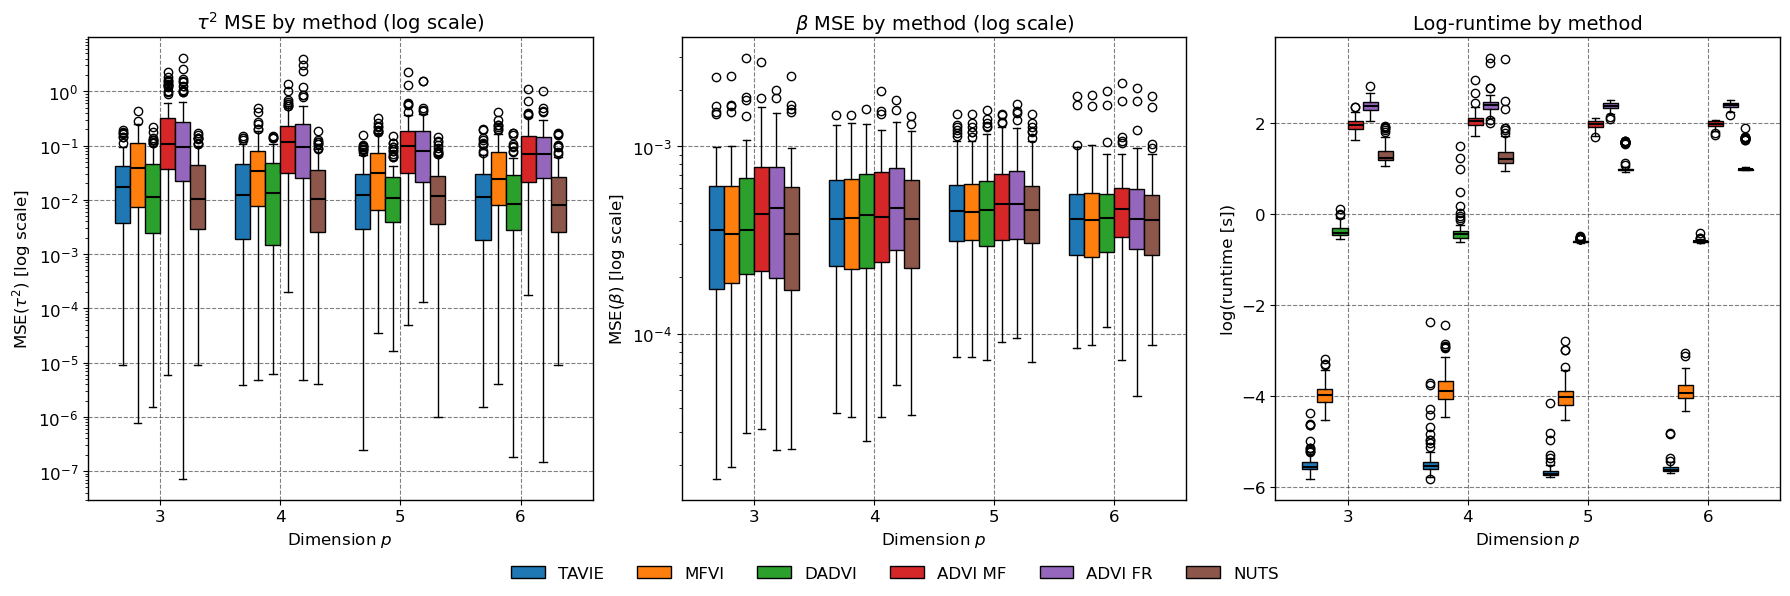

In [13]:
# plotting the results for TAVIE and competing methods over the choice of features p

methods   = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors    = ['C0',    'C1',    'C2',    'C3',     'C4',     'C5']
P         = len(p_values)
M         = len(methods)

# --- spacing controls ---
group_spacing = 8.0      # distance between p-groups on the x-axis (↑ for bigger gaps)
method_step   = 1     # separation between methods within each group
box_width     = 1     # visual width of each box

centers = np.arange(P) * group_spacing  # group centers for each p

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes spines, ticks, grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log on the DATA; axis stays linear)
ax = axes[2]
for j, arr in enumerate([time_TAVIE, time_MFVI, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Student_metrics_multi_p_n_{n}.png', dpi=300, bbox_inches='tight')
plt.show()

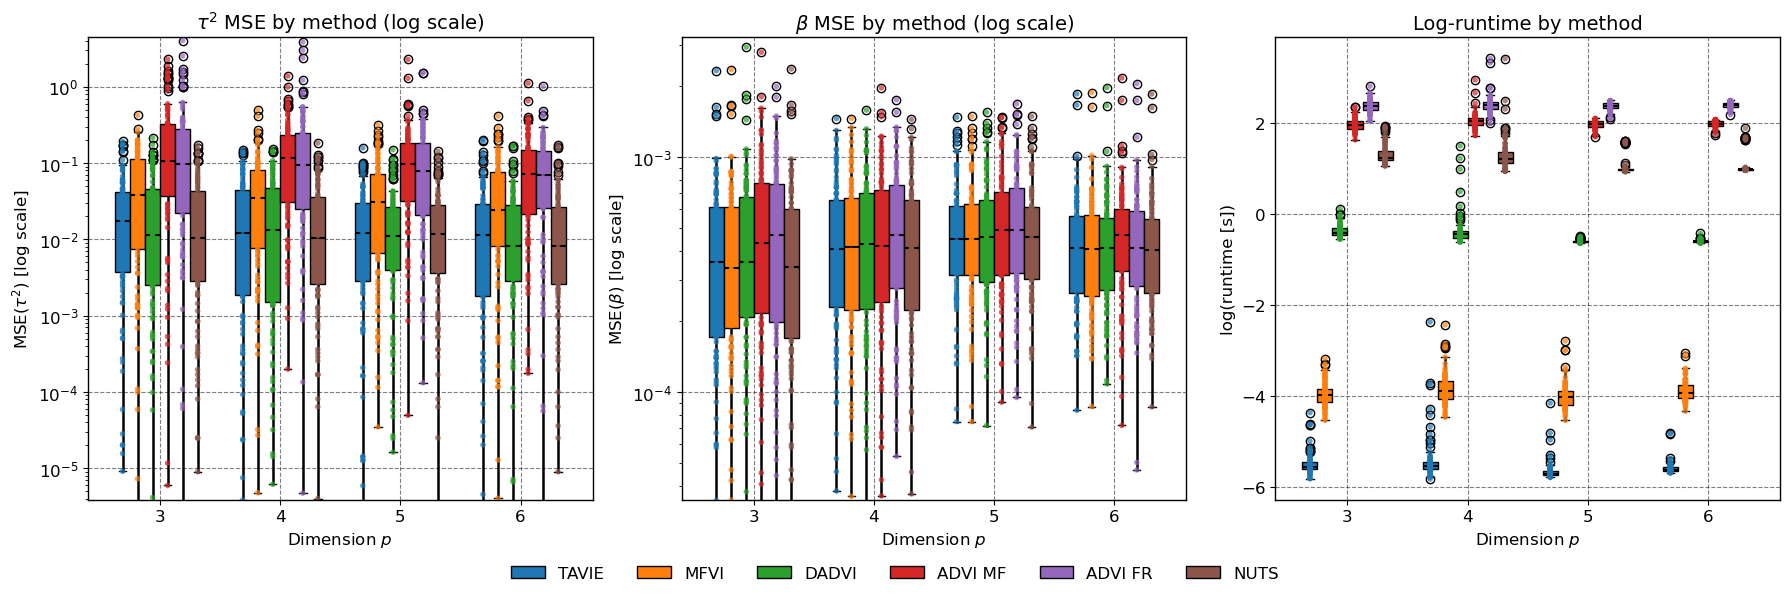

In [14]:
# --- METHODS & STYLES ---
methods = ['TAVIE', 'MFVI', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors  = ['C0',    'C1',    'C2',      'C3',     'C4',     'C5']
P       = len(p_values)
M       = len(methods)
eps     = 1e-16  # avoid log(0) on log-scale panels

# --- SPACING CONTROLS ---
group_spacing = 8.0    # gap between p-groups
method_step   = 1.0   # separation between methods within a group
box_width     = 1.0   # width of each box
centers       = np.arange(P) * group_spacing

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')

# Axes styling
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# Shared boxplot style (no whisker end caps)
bp_kwargs = dict(
    widths=box_width,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.8, color='black'),
    medianprops=dict(linewidth=1.5, color='black'),
)

# ---------------- 1) τ² MSE (log axis) ----------------
ax = axes[0]
all_vals_tau2 = []
series_tau2 = [mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, 
               mse_tau2_NUTS]
for j, arr in enumerate(series_tau2):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.asarray(arr[i, :])
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_tau2.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---------------- 2) β MSE (log axis) ----------------
ax = axes[1]
all_vals_beta = []
series_beta = [mse_beta_TAVIE, mse_beta_MFVI, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, 
               mse_beta_NUTS]
for j, arr in enumerate(series_beta):
    data = [np.clip(arr[i, :], eps, None) for i in range(P)]  # ensure > 0
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped) (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_beta.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---------------- 3) Runtime (log on data; linear axis) ----------------
ax = axes[2]
all_vals_time = []
series_time = [time_TAVIE, time_MFVI, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
for j, arr in enumerate(series_time):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay log-values (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_time.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', fontsize=12)
ax.set_ylabel('log(runtime [s])', fontsize=12)
ax.set_title('Log-runtime by method', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---------- Add headroom so nothing gets clipped ----------
if all_vals_tau2:
    all_tau2 = np.concatenate(all_vals_tau2)
    pos = all_tau2[all_tau2 > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10  # +10% headroom
    axes[0].set_ylim(ymin, ymax)

if all_vals_beta:
    all_beta = np.concatenate(all_vals_beta)
    pos = all_beta[all_beta > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10
    axes[1].set_ylim(ymin, ymax)

if all_vals_time:
    all_time_log = np.concatenate(all_vals_time)  # already log()
    lo, hi = np.min(all_time_log), np.max(all_time_log)
    pad = 0.05 * (hi - lo) if hi > lo else 0.1
    axes[2].set_ylim(lo - pad, hi + pad)

# Legend
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Student_metrics_multi_p_n_{n}_other.png', dpi=300, bbox_inches='tight')
plt.show()